In [12]:
# ruff: noqa: F401, E402, T201, T203, D103, B015, B018
from __future__ import annotations

import secrets
from pprint import pprint
from typing import Any, Iterable, Sequence

import matplotlib.image as img
import matplotlib.pyplot as plt
import networkx as nx
import numba as nb
import numpy as np
import seaborn as sns
from IPython.core.interactiveshell import InteractiveShell
from numpy import dtype, inf, ma, nan, ndarray
from numpy.polynomial import Polynomial as Poly
from numpy.polynomial import polynomial as poly

InteractiveShell.ast_node_interactivity = "all"
np.set_printoptions(edgeitems=5, precision=3, linewidth=300)

## Basics

In [20]:
np.empty((3, 5))
np.full((3, 5), 42)
np.zeros((3, 5))
np.ones((3, 5))

array([[0.837, 0.541, 0.088, 0.267, 0.478],
       [0.786, 0.286, 0.535, 0.12 , 0.049],
       [0.835, 0.802, 0.239, 0.295, 0.462]])

array([[42, 42, 42, 42, 42],
       [42, 42, 42, 42, 42],
       [42, 42, 42, 42, 42]])

array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])

array([[1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.]])

## Check if vector is in the array

### Naive

In [4]:
# Determine if a vector is in NDarray
a = np.arange(15).reshape((3, 5))
a
[0, 1, 2, 3, 4] in a  # Any
(25, 1, 2, 3, 4) in a  # Any
14 in a
25 in a
print("tolist")
[0, 1, 2, 3, 4] in a.tolist()
(0, 1, 2, 3, 4) in a.tolist()
[1, 1, 2, 3, 4] in a.tolist()

array([[ 0,  1,  2,  3,  4],
       [ 5,  6,  7,  8,  9],
       [10, 11, 12, 13, 14]])

True

True

True

False

tolist


True

False

False

### Rabin-Karp

In [5]:
@nb.jit
def sum_hash(it: Iterable) -> int:
    s: int = 0
    for e in it:
        s += hash(e)
    return s


@nb.jit
def match(seq: ndarray, subseq: ndarray, start: int) -> bool:
    return np.array_equal(seq[start : start + len(subseq)], subseq)

In [6]:
@nb.jit
def find_rk(seq: ndarray, subseq: ndarray) -> None:
    """Search `seq` for `subseq` using Rabin-Karp over numpy arrays."""
    n: int = len(seq)
    m: int = len(subseq)
    h1: int = sum_hash(seq[:m])
    h2: int = sum_hash(subseq)
    if h1 == h2 and match(seq, subseq, 0):
        yield 0
    for i in range(n - m):
        h1 += hash(seq[i + m]) - hash(seq[i])
        if h1 == h2 and match(seq, subseq, i + 1):
            yield i + 1

In [7]:
seq: ndarray = np.array([[1, 2, 3, 4], [5, 2, 3, 1], [2, 3, 2, 3]]).flatten()
list(find_rk(seq, np.array([2, 3])))

[1, 5, 8, 10]

## NA Rows / Columns

In [31]:
# Remove rows  with invalid (nan, inf) values
a = np.array([[0, 1, 2, 3, 4], [5, 6, np.nan, 8, 9], [10, 11, 12, 13, 14]])
a
m = ma.masked_invalid(a)
m
r = ma.compress_rows(m)
r

a[~np.isnan(a).any(axis=1),]

array([[ 0.,  1.,  2.,  3.,  4.],
       [ 5.,  6., nan,  8.,  9.],
       [10., 11., 12., 13., 14.]])

masked_array(
  data=[[0.0, 1.0, 2.0, 3.0, 4.0],
        [5.0, 6.0, --, 8.0, 9.0],
        [10.0, 11.0, 12.0, 13.0, 14.0]],
  mask=[[False, False, False, False, False],
        [False, False,  True, False, False],
        [False, False, False, False, False]],
  fill_value=1e+20)

array([[ 0.,  1.,  2.,  3.,  4.],
       [10., 11., 12., 13., 14.]])

array([[ 0.,  1.,  2.,  3.,  4.],
       [10., 11., 12., 13., 14.]])

In [30]:
# Remove columns with invalid (nan, inf) values
a = np.array([[0, 1, 2, 3, 4], [5, 6, np.nan, 8, 9], [10, 11, 12, 13, 14]])
m = ma.masked_invalid(a)
c = ma.compress_cols(m)
c

a[:, ~np.isnan(a).any(axis=0)]

array([[ 0.,  1.,  3.,  4.],
       [ 5.,  6.,  8.,  9.],
       [10., 11., 13., 14.]])

array([[ 0.,  1.,  3.,  4.],
       [ 5.,  6.,  8.,  9.],
       [10., 11., 13., 14.]])

In [63]:
# Remove rows and columns with invalid (nan, inf) values
a = np.array([[0, 1, 2, 3, 4], [5, 6, np.nan, 8, 9], [10, 11, 12, 13, 14]])
m = ma.masked_invalid(a)
rc = ma.compress_rowcols(m)
rc

array([[ 0.,  1.,  3.,  4.],
       [10., 11., 13., 14.]])

## Remove dimensions of size 1

In [9]:
a = np.arange(15).reshape((1, 3, 5))
a
a.squeeze()

array([[[ 0,  1,  2,  3,  4],
        [ 5,  6,  7,  8,  9],
        [10, 11, 12, 13, 14]]])

array([[ 0,  1,  2,  3,  4],
       [ 5,  6,  7,  8,  9],
       [10, 11, 12, 13, 14]])

## Most Frequent Value

In [10]:
a: ndarray = np.array([[1, 2, 2, 2, 4], [3, 4, 2, 5, 1], [5, 2, 7, 8, 9]])
a
bc = np.bincount(a.flat)
bc
bc.argmax()

array([[1, 2, 2, 2, 4],
       [3, 4, 2, 5, 1],
       [5, 2, 7, 8, 9]])

array([0, 2, 5, 1, 2, 2, 0, 1, 1, 1])

2

In [63]:
a = np.array([[1, 2, 2, 2, 4], [3, 4, 2, 5, 1], [5, 2, 7, 8, 9]])
nums, counts = np.unique(a, return_counts=1)
nums
counts
nums[np.argmax(counts)]

array([1, 2, 3, 4, 5, 7, 8, 9])

array([2, 5, 1, 2, 2, 1, 1, 1])

2

## Combine 1D and 2D array

In [11]:
a = np.array([[1, 2, 4], [6, 5, 3]])
b = np.array([3, 2, 1])

np.block([[a], [b]])

array([[1, 2, 4],
       [6, 5, 3],
       [3, 2, 1]])

## Combinations

In [12]:
a: ndarray = np.arange(5)
b: ndarray = np.arange(5) + 10

np.array(np.meshgrid(a, b)).shape
np.array(np.meshgrid(a, b)).T.shape
np.array(np.meshgrid(a, b)).T.reshape(-1, 2)

(2, 5, 5)

(5, 5, 2)

array([[ 0, 10],
       [ 0, 11],
       [ 0, 12],
       [ 0, 13],
       [ 0, 14],
       [ 1, 10],
       [ 1, 11],
       [ 1, 12],
       [ 1, 13],
       [ 1, 14],
       [ 2, 10],
       [ 2, 11],
       [ 2, 12],
       [ 2, 13],
       [ 2, 14],
       [ 3, 10],
       [ 3, 11],
       [ 3, 12],
       [ 3, 13],
       [ 3, 14],
       [ 4, 10],
       [ 4, 11],
       [ 4, 12],
       [ 4, 13],
       [ 4, 14]])

In [62]:
a: ndarray = np.arange(5)
b: ndarray = np.arange(5) + 10
np.concatenate(np.dstack(np.meshgrid(a, b)))

array([[ 0, 10],
       [ 1, 10],
       [ 2, 10],
       [ 3, 10],
       [ 4, 10],
       [ 0, 11],
       [ 1, 11],
       [ 2, 11],
       [ 3, 11],
       [ 4, 11],
       [ 0, 12],
       [ 1, 12],
       [ 2, 12],
       [ 3, 12],
       [ 4, 12],
       [ 0, 13],
       [ 1, 13],
       [ 2, 13],
       [ 3, 13],
       [ 4, 13],
       [ 0, 14],
       [ 1, 14],
       [ 2, 14],
       [ 3, 14],
       [ 4, 14]])

(0.0, 29.999995141332942)

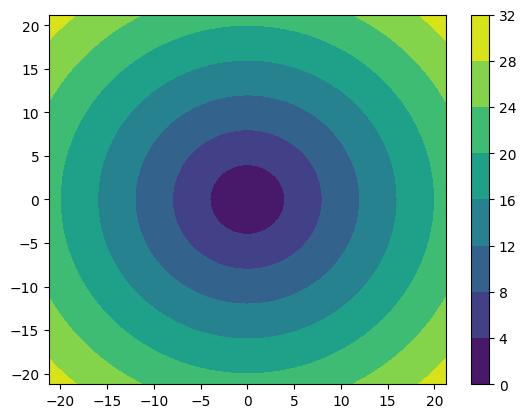

In [22]:
x: ndarray = np.linspace(-21.2132, 21.2132, 101)
y: ndarray = np.linspace(-21.2132, 21.2132, 101)
xx, yy = np.meshgrid(x, y, sparse=True)
zz = np.sqrt(xx**2 + yy**2)
zz.min(), zz.max()

_ = plt.contourf(x, y, zz)
_ = plt.colorbar()
_ = plt.show()

## How to add border?

In [14]:
a = np.arange(16).reshape((4, 4))
np.pad(a, 1)

array([[ 0,  0,  0,  0,  0,  0],
       [ 0,  0,  1,  2,  3,  0],
       [ 0,  4,  5,  6,  7,  0],
       [ 0,  8,  9, 10, 11,  0],
       [ 0, 12, 13, 14, 15,  0],
       [ 0,  0,  0,  0,  0,  0]])

## Compare two ndarrays?

In [15]:
a: ndarray = np.array([1, 2, 3, 4])
b: ndarray = np.array([2, 4, 6, 8])

np.array_equal(a, b)
a == b
np.less_equal(a, b)
a < b

False

array([False, False, False, False])

array([ True,  True,  True,  True])

array([ True,  True,  True,  True])

## Check if value is in ndarray?

In [16]:
a: ndarray = np.array([1, 2, 3, 4])
b: ndarray = np.array([2, 4, 6, 8])

3 in a

(a == 3).any()

True

True

## Diagonals of a 3D array

In [17]:
a = np.arange(27).reshape((3, 3, 3))
a

d1 = np.diagonal(a)
d1
d2 = np.diagonal(a, axis1=0, axis2=2)
d2
d3 = np.diagonal(a, axis1=1, axis2=2)
d3

array([[[ 0,  1,  2],
        [ 3,  4,  5],
        [ 6,  7,  8]],

       [[ 9, 10, 11],
        [12, 13, 14],
        [15, 16, 17]],

       [[18, 19, 20],
        [21, 22, 23],
        [24, 25, 26]]])

array([[ 0, 12, 24],
       [ 1, 13, 25],
       [ 2, 14, 26]])

array([[ 0, 10, 20],
       [ 3, 13, 23],
       [ 6, 16, 26]])

array([[ 0,  4,  8],
       [ 9, 13, 17],
       [18, 22, 26]])

In [18]:
np.diagonal(d1)
np.diagonal(np.flipud(d1))
np.diagonal(np.flipud(d2))
np.diagonal(np.fliplr(d3))

array([ 0, 13, 26])

array([ 2, 13, 24])

array([ 6, 13, 20])

array([ 8, 13, 18])

## Flatten Matrix

In [19]:
a = np.arange(27).reshape((3, 3, 3))
a
a.flatten()

array([[[ 0,  1,  2],
        [ 3,  4,  5],
        [ 6,  7,  8]],

       [[ 9, 10, 11],
        [12, 13, 14],
        [15, 16, 17]],

       [[18, 19, 20],
        [21, 22, 23],
        [24, 25, 26]]])

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26])

## Move / Swap Axes

In [20]:
a = np.arange(27).reshape((3, 3, 3))
a
np.moveaxis(a, 1, 2)

array([[[ 0,  1,  2],
        [ 3,  4,  5],
        [ 6,  7,  8]],

       [[ 9, 10, 11],
        [12, 13, 14],
        [15, 16, 17]],

       [[18, 19, 20],
        [21, 22, 23],
        [24, 25, 26]]])

array([[[ 0,  3,  6],
        [ 1,  4,  7],
        [ 2,  5,  8]],

       [[ 9, 12, 15],
        [10, 13, 16],
        [11, 14, 17]],

       [[18, 21, 24],
        [19, 22, 25],
        [20, 23, 26]]])

In [21]:
b = np.arange(24).reshape((2, 3, 4))
b.shape
b
np.moveaxis(b, 1, 2).shape
np.moveaxis(b, 1, 2)
np.swapaxes(b, 1, 2).shape
np.swapaxes(b, 1, 2)

(2, 3, 4)

array([[[ 0,  1,  2,  3],
        [ 4,  5,  6,  7],
        [ 8,  9, 10, 11]],

       [[12, 13, 14, 15],
        [16, 17, 18, 19],
        [20, 21, 22, 23]]])

(2, 4, 3)

array([[[ 0,  4,  8],
        [ 1,  5,  9],
        [ 2,  6, 10],
        [ 3,  7, 11]],

       [[12, 16, 20],
        [13, 17, 21],
        [14, 18, 22],
        [15, 19, 23]]])

(2, 4, 3)

array([[[ 0,  4,  8],
        [ 1,  5,  9],
        [ 2,  6, 10],
        [ 3,  7, 11]],

       [[12, 16, 20],
        [13, 17, 21],
        [14, 18, 22],
        [15, 19, 23]]])

In [22]:
np.moveaxis(b, 0, 2).shape
np.moveaxis(b, 0, 2)
np.swapaxes(b, 0, 2).shape
np.swapaxes(b, 0, 2)

(3, 4, 2)

array([[[ 0, 12],
        [ 1, 13],
        [ 2, 14],
        [ 3, 15]],

       [[ 4, 16],
        [ 5, 17],
        [ 6, 18],
        [ 7, 19]],

       [[ 8, 20],
        [ 9, 21],
        [10, 22],
        [11, 23]]])

(4, 3, 2)

array([[[ 0, 12],
        [ 4, 16],
        [ 8, 20]],

       [[ 1, 13],
        [ 5, 17],
        [ 9, 21]],

       [[ 2, 14],
        [ 6, 18],
        [10, 22]],

       [[ 3, 15],
        [ 7, 19],
        [11, 23]]])

## Fibonacci Series

In [23]:
@nb.jit
def imatmul2d(a: ndarray, b: ndarray) -> None:
    a[0, 0], a[0, 1], a[1, 0], a[1, 1] = (
        a[0, 0] * b[0, 0] + a[0, 1] * b[1, 0],
        a[0, 0] * b[0, 1] + a[0, 1] * b[1, 1],
        a[1, 0] * b[0, 0] + a[1, 1] * b[1, 0],
        a[1, 0] * b[0, 1] + a[1, 1] * b[1, 1],
    )


@nb.jit
def imatmul1d2d(a: ndarray, b: ndarray) -> None:
    a[0], a[1] = (a[0] * b[0, 0] + a[1] * b[1, 0], a[0] * b[0, 1] + a[1] * b[1, 1])


@nb.jit
def fib(n: int) -> int:
    """Return fibonacci number: `(fib(n-1) + fib(n-2))`."""  # noqa: D402
    # Runs in O(log N)
    mat: ndarray = np.array([[1, 1], [1, 0]], dtype=np.int64)
    res: ndarray = np.array([1, 0], dtype=np.int64)
    n -= 2
    while n > 0:
        if n & 1:
            imatmul1d2d(res, mat)
        imatmul2d(mat, mat)
        n >>= 1
    return res[0] + res[1]

In [24]:
fib(3)
fib(10)

2

55

## Count non-zero elements

In [25]:
b = np.arange(24).reshape((2, 3, 4))
b.shape
b
np.count_nonzero(b)

(2, 3, 4)

array([[[ 0,  1,  2,  3],
        [ 4,  5,  6,  7],
        [ 8,  9, 10, 11]],

       [[12, 13, 14, 15],
        [16, 17, 18, 19],
        [20, 21, 22, 23]]])

23

## Size


In [26]:
b = np.arange(24).reshape((2, 3, 4))
b.shape
b
np.size(b)
np.size(b, axis=0)
np.size(b, axis=1)
np.size(b, axis=2)

(2, 3, 4)

array([[[ 0,  1,  2,  3],
        [ 4,  5,  6,  7],
        [ 8,  9, 10, 11]],

       [[12, 13, 14, 15],
        [16, 17, 18, 19],
        [20, 21, 22, 23]]])

24

2

3

4

## Trim Zeros

In [30]:
b = np.arange(5)
b.shape
b
p = np.pad(b, 3)
p
np.trim_zeros(p)

(5,)

array([0, 1, 2, 3, 4])

array([0, 0, 0, 0, 1, 2, 3, 4, 0, 0, 0])

array([1, 2, 3, 4])

## Change Data Type

In [32]:
b = np.arange(5)

f = np.asarray(b, dtype=float)
f

array([0., 1., 2., 3., 4.])

## Reverse

In [33]:
np.flip(np.arange(5))

array([4, 3, 2, 1, 0])

## Read-Only

In [38]:
a = np.arange(5)
a.flags
a.flags["W"] = False
a

  C_CONTIGUOUS : True
  F_CONTIGUOUS : True
  OWNDATA : True
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False

array([0, 1, 2, 3, 4])

In [44]:
a = np.array([1, 2, 3, 4, 5])
a.flags
a.flags.writeable = False
a.flags
a.setflags(write=True)
a.flags

  C_CONTIGUOUS : True
  F_CONTIGUOUS : True
  OWNDATA : True
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False

  C_CONTIGUOUS : True
  F_CONTIGUOUS : True
  OWNDATA : True
  WRITEABLE : False
  ALIGNED : True
  WRITEBACKIFCOPY : False

  C_CONTIGUOUS : True
  F_CONTIGUOUS : True
  OWNDATA : True
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False

## Sum of values

In [45]:
b = np.arange(6).reshape((2, 3))
b.shape
b
b.sum()

(2, 3)

array([[0, 1, 2],
       [3, 4, 5]])

15

In [47]:
b = np.arange(9).reshape((3, 3))
b.shape
b
b.trace()

(3, 3)

array([[0, 1, 2],
       [3, 4, 5],
       [6, 7, 8]])

12

## +/-

In [48]:
a = np.array([[1, 2], [3, 4]])
b = np.array([[4, 5], [6, 7]])

a + b
a - b

array([[ 5,  7],
       [ 9, 11]])

array([[-3, -3],
       [-3, -3]])

## Insert / Add

In [59]:
a = np.array([[1, 2], [3, 4]])

np.insert(a, 1, [5, 6], axis=0)
np.insert(a, 1, [5, 6], axis=1)

array([[1, 2],
       [5, 6],
       [3, 4]])

array([[1, 5, 2],
       [3, 6, 4]])

In [54]:
a = np.array([[1, 2], [3, 4]])
np.block([[a], [5, 6]])
np.vstack((a, [5, 6]))
np.hstack((a, np.array([[5, 6]]).T))

array([[1, 2],
       [3, 4],
       [5, 6]])

array([[1, 2],
       [3, 4],
       [5, 6]])

array([[1, 2, 5],
       [3, 4, 6]])

## Outer / Inner / Cross

In [80]:
a = np.array([1, 2, 3])
b = np.array([1, 2, 0])
np.outer(a, b)
np.inner(a, b)
np.dot(a, b)
np.cross(a, b)

array([[1, 2, 0],
       [2, 4, 0],
       [3, 6, 0]])

5

5

array([-6,  3,  0])

## Covariance / Correlation

In [116]:
a = np.array([1, 2, 3, 8, 3])
b = np.array([1, 2, 0, -1, 3])

np.cov(a, b)
np.corrcoef(a, b)

array([[ 7.3 , -2.75],
       [-2.75,  2.5 ]])

array([[ 1.        , -0.64372631],
       [-0.64372631,  1.        ]])

In [119]:
a = np.array([1, 2, 3, 8, 3])
b = np.array([1, 2, 0, -1, 3])

c = np.cov(a, b)
c

invd = np.diag(1 / np.sqrt(c.diagonal()))
invd

invd @ c @ invd

array([[ 7.3 , -2.75],
       [-2.75,  2.5 ]])

array([[0.37011661, 0.        ],
       [0.        , 0.63245553]])

array([[ 1.        , -0.64372631],
       [-0.64372631,  1.        ]])

In [ ]:
# Pearson Product-Moment Correlation Coefficient.

a = np.arange(6).reshape(2, 3)
a
b = (3 - a) * 2
b

np.corrcoef(a, b)

array([[0, 1, 2],
       [3, 4, 5]])

array([[ 6,  4,  2],
       [ 0, -2, -4]])

array([[ 1.,  1., -1., -1.],
       [ 1.,  1., -1., -1.],
       [-1., -1.,  1.,  1.],
       [-1., -1.,  1.,  1.]])

In [ ]:
rng = np.random.default_rng()
a = rng.normal(0, 3.0, size=10)
b = rng.uniform(0, 3.0, size=10)
a, b

np.corrcoef(a, b)

(array([-1.184, -0.102,  3.647, -3.912, -3.427,  3.399,  5.848, -2.539,  3.387,  2.025]),
 array([0.174, 0.84 , 0.894, 2.35 , 0.561, 0.025, 0.306, 1.505, 2.005, 0.318]))

array([[ 1.   , -0.369],
       [-0.369,  1.   ]])

In [ ]:
rng = np.random.default_rng()
a = rng.normal(0, 3.0, size=9).reshape((3, 3))
b = rng.uniform(0, 3.0, size=9).reshape((3, 3))
a, b

np.corrcoef(a, b)

(array([[ 3.533, -0.67 , -2.932],
        [ 4.474, -0.341, -0.385],
        [ 0.829, -3.134,  2.881]]),
 array([[0.892, 2.953, 1.652],
        [1.32 , 1.668, 2.613],
        [2.786, 2.29 , 2.499]]))

array([[ 1.   ,  0.941, -0.17 , -0.518, -0.908,  0.707],
       [ 0.941,  1.   ,  0.173, -0.776, -0.713,  0.904],
       [-0.17 ,  0.173,  1.   , -0.755,  0.567,  0.577],
       [-0.518, -0.776, -0.755,  1.   ,  0.112, -0.971],
       [-0.908, -0.713,  0.567,  0.112,  1.   , -0.346],
       [ 0.707,  0.904,  0.577, -0.971, -0.346,  1.   ]])

In [ ]:
c = np.cov(a, b)
c
c / np.std(a) / np.std(b)

array([[10.763,  8.625, -1.702, -1.772, -1.993,  0.578],
       [ 8.625,  7.8  ,  1.476, -2.26 , -1.333,  0.629],
       [-1.702,  1.476,  9.349, -2.406,  1.16 ,  0.439],
       [-1.772, -2.26 , -2.406,  1.086,  0.078, -0.252],
       [-1.993, -1.333,  1.16 ,  0.078,  0.448, -0.058],
       [ 0.578,  0.629,  0.439, -0.252, -0.058,  0.062]])

array([[ 6.244,  5.004, -0.987, -1.028, -1.156,  0.335],
       [ 5.004,  4.525,  0.856, -1.311, -0.773,  0.365],
       [-0.987,  0.856,  5.424, -1.396,  0.673,  0.255],
       [-1.028, -1.311, -1.396,  0.63 ,  0.045, -0.146],
       [-1.156, -0.773,  0.673,  0.045,  0.26 , -0.033],
       [ 0.335,  0.365,  0.255, -0.146, -0.033,  0.036]])

In [ ]:
c = np.cov(a.flat, b.flat)
c
c / np.std(a.flat) / np.std(b.flat)

array([[ 7.326, -0.729],
       [-0.729,  0.513]])

array([[ 4.25 , -0.423],
       [-0.423,  0.298]])

## Kronecker Product

In [6]:
a = np.array([[1, 2], [3, 5]])
b = np.array([[10, -20], [100, -200]])

np.kron(a, b)

array([[   10,   -20,    20,   -40],
       [  100,  -200,   200,  -400],
       [   30,   -60,    50,  -100],
       [  300,  -600,   500, -1000]])

## Convert To List

In [9]:
a = np.array([[1, 2], [3, 5]])
list(a)

a.flatten()

a.tolist()

[array([1, 2]), array([3, 5])]

array([1, 2, 3, 5])

[[1, 2], [3, 5]]

## Replace elements conditionally

In [23]:
a = np.array([[1, 2], [3, 5]])

c = (a % 2) == 0
c
c = (a & 1) == 0
c
a[c] = 7
a

np.where(c, -1, a)

array([[False,  True],
       [False, False]])

array([[False,  True],
       [False, False]])

array([[1, 7],
       [3, 5]])

array([[ 1, -1],
       [ 3,  5]])

## True Indexes

In [28]:
a = np.array([[1, 2, 7], [4, 3, 2]])

np.argwhere(a & 1)

array([[0, 0],
       [0, 2],
       [1, 1]])

## Replace NaN with column avg.

In [51]:
a = np.array([[nan, 2, 7], [4, nan, 2], [nan, 9, nan]])
a
a[2, 0]
a[0, 2]
i = np.nonzero(np.isnan(a))
print("row", "column")
i
a[i] = np.take(np.nanmean(a, axis=0), i[1])
a

array([[nan,  2.,  7.],
       [ 4., nan,  2.],
       [nan,  9., nan]])

nan

7.0

row column


(array([0, 1, 2, 2]), array([0, 1, 0, 2]))

array([[4. , 2. , 7. ],
       [4. , 5.5, 2. ],
       [4. , 9. , 4.5]])

In [46]:
a = np.array([[nan, 2, 7], [4, nan, 2], [nan, 9, nan]])
a
# Broadcast the
np.where(np.isnan(a), np.nanmean(a, axis=0), a)

array([[nan,  2.,  7.],
       [ 4., nan,  2.],
       [nan,  9., nan]])

array([[4. , 2. , 7. ],
       [4. , 5.5, 2. ],
       [4. , 9. , 4.5]])

## Replace negative with zero

In [53]:
a = np.array([[-1, 2, 7], [4, -2, 2], [-3, 9, -12]])
a
a[a < 0] = 0
a

array([[ -1,   2,   7],
       [  4,  -2,   2],
       [ -3,   9, -12]])

array([[0, 2, 7],
       [4, 0, 2],
       [0, 9, 0]])

In [54]:
a = np.array([[-1, 2, 7], [4, -2, 2], [-3, 9, -12]])
a
a.clip(0)

array([[ -1,   2,   7],
       [  4,  -2,   2],
       [ -3,   9, -12]])

array([[0, 2, 7],
       [4, 0, 2],
       [0, 9, 0]])

In [56]:
a = np.array([[-1, 2, 7], [4, -2, 2], [-3, 9, -12]])
a
np.maximum(a, 0)

array([[ -1,   2,   7],
       [  4,  -2,   2],
       [ -3,   9, -12]])

array([[0, 2, 7],
       [4, 0, 2],
       [0, 9, 0]])

## Zero Index

In [72]:
a = np.array([[0, 2, 7], [4, 0, 2], [0, 9, 0]])
a.shape
np.argwhere(a == 0)
np.nonzero(a == 0)
np.array(np.nonzero(a == 0)).T
np.stack(np.nonzero(a == 0), axis=1)

(3, 3)

array([[0, 0],
       [1, 1],
       [2, 0],
       [2, 2]])

(array([0, 1, 2, 2]), array([0, 1, 0, 2]))

array([[0, 0],
       [1, 1],
       [2, 0],
       [2, 2]])

array([[0, 0],
       [1, 1],
       [2, 0],
       [2, 2]])

## Access Columns, Rows

In [42]:
a = np.array([[0, 2, 7], [4, 0, 2], [0, 9, 0]])
a
a[..., [2, 1]]
a[:, [2, 1]]
a[[2, 1],]

array([[0, 2, 7],
       [4, 0, 2],
       [0, 9, 0]])

array([[7, 2],
       [2, 0],
       [0, 9]])

array([[7, 2],
       [2, 0],
       [0, 9]])

array([[0, 9, 0],
       [4, 0, 2]])

## Row numbers with element larger than X

In [47]:
a = np.array([[0, 2, 7], [4, 0, 2], [0, 9, 0], [1, 3, 0], [11, 3, 0], [1, 3, 6]])

np.argwhere(a > 5)[:, 0]

array([0, 2, 4, 5])

In [49]:
np.nonzero((a > 5).any(axis=1))

(array([0, 2, 4, 5]),)

## Fill the diagonals

In [53]:
a = np.arange(16).reshape((4, 4))
a
a[np.diag_indices_from(a)] = 33
a

array([[ 0,  1,  2,  3],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11],
       [12, 13, 14, 15]])

array([[33,  1,  2,  3],
       [ 4, 33,  6,  7],
       [ 8,  9, 33, 11],
       [12, 13, 14, 33]])

In [54]:
a = np.arange(16).reshape((4, 4))
np.fill_diagonal(a, 33)
a

array([[33,  1,  2,  3],
       [ 4, 33,  6,  7],
       [ 8,  9, 33, 11],
       [12, 13, 14, 33]])

## Check if elements are in array

In [55]:
h = np.array([[0, 2, 7], [4, 0, 2], [0, 9, 0], [1, 3, 0], [11, 3, 0], [1, 3, 6]])
np.isin([5, 4, 3], h)

array([False,  True,  True])

In [56]:
np.isin([[5, 4, 3], [1, 2, 3]], h)

array([[False,  True,  True],
       [ True,  True,  True]])

## Combine two on the 3rd dimension

In [64]:
a: ndarray = np.arange(5)
b: ndarray = np.arange(5) + 10

m = np.meshgrid(a, b)
m
np.dstack(m)

[array([[0, 1, 2, 3, 4],
        [0, 1, 2, 3, 4],
        [0, 1, 2, 3, 4],
        [0, 1, 2, 3, 4],
        [0, 1, 2, 3, 4]]),
 array([[10, 10, 10, 10, 10],
        [11, 11, 11, 11, 11],
        [12, 12, 12, 12, 12],
        [13, 13, 13, 13, 13],
        [14, 14, 14, 14, 14]])]

array([[[ 0, 10],
        [ 1, 10],
        [ 2, 10],
        [ 3, 10],
        [ 4, 10]],

       [[ 0, 11],
        [ 1, 11],
        [ 2, 11],
        [ 3, 11],
        [ 4, 11]],

       [[ 0, 12],
        [ 1, 12],
        [ 2, 12],
        [ 3, 12],
        [ 4, 12]],

       [[ 0, 13],
        [ 1, 13],
        [ 2, 13],
        [ 3, 13],
        [ 4, 13]],

       [[ 0, 14],
        [ 1, 14],
        [ 2, 14],
        [ 3, 14],
        [ 4, 14]]])

## LinAlg

### Matrix Norm

In [85]:
a = np.arange(16).reshape((4, 4))
a
"fro", np.linalg.norm(a)
1, np.linalg.norm(a, 1)
-1, np.linalg.norm(a, -1)
2, np.linalg.norm(a, 2)
-2, np.linalg.norm(a, -2)
"inf", np.linalg.norm(a, inf)
"-inf", np.linalg.norm(a, -inf)

"nuc", np.linalg.norm(a, "nuc")

array([[ 0,  1,  2,  3],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11],
       [12, 13, 14, 15]])

('fro', 35.21363372331802)

(1, 36.0)

(-1, 24.0)

(2, 35.13996365902469)

(-2, 9.848750822853081e-17)

('inf', 54.0)

('-inf', 6.0)

('nuc', 37.41657386773941)

In [82]:
a = np.arange(16).reshape((4, 4))
a
np.max(np.sum(np.abs(a), axis=0))
np.max(np.sum(np.abs(a), axis=1))

array([[ 0,  1,  2,  3],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11],
       [12, 13, 14, 15]])

36

54

In [47]:
v = np.array([1, 2, -2])
np.linalg.norm(v, 1)
np.linalg.norm(v, 2)

5.0

3.0

### Determinant

In [ ]:
a = np.array([[1, 2], [3, 4]])
np.linalg.det(a)

-2.0000000000000004

In [ ]:
a = np.eye(3)
np.linalg.det(a)

1.0

### Inverse

In [ ]:
a = np.eye(3)
np.linalg.inv(a)

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [ ]:
a = np.array([[1, 2], [3, 4]])
a
i = np.linalg.inv(a)
i

a @ i

array([[1, 2],
       [3, 4]])

array([[-2. ,  1. ],
       [ 1.5, -0.5]])

array([[1.0000000e+00, 0.0000000e+00],
       [8.8817842e-16, 1.0000000e+00]])

### QR Decomposition

In [17]:
a = np.arange(16).reshape((4, 4))

q, r = np.linalg.qr(a)
q
r

array([[ 0.   , -0.837,  0.541,  0.088],
       [-0.267, -0.478, -0.786,  0.286],
       [-0.535, -0.12 , -0.049, -0.835],
       [-0.802,  0.239,  0.295,  0.462]])

array([[-1.497e+01, -1.657e+01, -1.817e+01, -1.978e+01],
       [ 0.000e+00, -1.195e+00, -2.390e+00, -3.586e+00],
       [ 0.000e+00,  0.000e+00, -3.820e-15, -4.311e-15],
       [ 0.000e+00,  0.000e+00,  0.000e+00,  7.744e-17]])

### Condition Number

Describes the relative quotient of change for $Ax = y$ between `dx` (solution) and `dy` (input). 
$$\frac{||dx||}{||x||} \leq k(A)  \frac{||dy||}{||y||}$$ 
  

In [44]:
a = (np.arange(16).reshape((4, 4)) - 10) / 30.0

np.linalg.det(a)
n = np.linalg.norm(a)
"||a||", n
invn = np.linalg.norm(np.linalg.inv(a))
"||a-1||", invn
"||a|| * ||a-1||", n * invn

"||a||_max_1 / ||a||_min_1", np.linalg.norm(a, 1) / np.linalg.norm(a, -1)
"||a||_max_2 / ||a||_min_2", np.linalg.norm(a, 2) / np.linalg.norm(a, -2)

"cond", np.linalg.cond(a)

-1.2839532962581623e-35

('||a||', 0.699205898780101)

('||a-1||', 1.7353766674558582e+17)

('||a|| * ||a-1||', 1.2133856024904898e+17)

('||a||_max_1 / ||a||_min_1', 1.25)

('||a||_max_2 / ||a||_min_2', 8.511418100523576e+16)

('cond', 8.511418100523576e+16)

### Eigenvalues and vectors

Eigenvalues represent the characteristic response of a matrix with respect to the eigenvector.
$$Av = \lambda v$$

In [51]:
a = (np.arange(16).reshape((4, 4)) - 10) / 30.0

np.linalg.eig(a)

EigResult(eigenvalues=array([-5.082e-01, -1.195e-17,  1.749e-01,  2.680e-17]), eigenvectors=array([[ 0.835, -0.548, -0.503,  0.317],
       [ 0.495,  0.73 , -0.074, -0.089],
       [ 0.154,  0.183,  0.355, -0.772],
       [-0.186, -0.365,  0.784,  0.544]]))


In [ ]:
a = np.array([[1, 2], [3, 4]])
np.linalg.eig(a)

EigResult(eigenvalues=array([-0.37228,  5.37228]), eigenvectors=array([[-0.82456, -0.41597],
       [ 0.56577, -0.90938]]))

In [ ]:
a = np.eye(3)
np.linalg.eig(a)

EigResult(eigenvalues=array([1., 1., 1.]), eigenvectors=array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]]))

### Euclidean Distance

In [53]:
a: ndarray = np.arange(5)
b: ndarray = np.arange(5) + 10

np.linalg.norm(a - b)  # 2 norm

22.360679774997898

In [58]:
d = a - b

np.sqrt(np.dot(d, d))

22.360679774997898

In [59]:
np.sqrt(np.sum(d**2))

22.360679774997898

## Random

In [91]:
rng = np.random.default_rng()

### Random Array

In [92]:
rng.random(10)

array([0.191, 0.582, 0.993, 0.463, 0.747, 0.953, 0.856, 0.453, 0.931, 0.675])

In [99]:
rng.uniform(-5, 5, size=10)

array([-2.797, -2.069,  0.733,  1.568,  2.504,  3.947,  4.599,  3.54 ,  1.731, -0.448])

In [93]:
rng.integers(0, 10, size=10)

array([2, 7, 5, 8, 1, 7, 3, 5, 6, 0])

In [98]:
np.empty(10)

array([0.565, 0.388, 0.332, 0.143, 0.811, 0.697, 0.711, 0.857, 0.438, 0.41 ])

### Choose by probability

In [90]:
a = np.array([9.9, 0.1, 0.1, 0.1, 0.1, 0.1, 0.9, 0.1, 0.1, 0.1])
a
p = a / a.sum()
s = np.array(list("abcdefghij"))
s
rng.choice(s, p=p, size=10)

array([9.9, 0.1, 0.1, 0.1, 0.1, 0.1, 0.9, 0.1, 0.1, 0.1])

array(['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j'], dtype='<U1')

array(['a', 'a', 'a', 'a', 'a', 'a', 'a', 'c', 'a', 'a'], dtype='<U1')

## Sorting / Searching

### Sorted Idices

In [105]:
a = rng.integers(1, 20, size=20)
a
np.argsort(a)

array([17,  9,  2, 17,  5,  7, 16, 12,  3, 13, 18,  2,  1,  3, 13,  5,  5,  3, 16,  6])

array([12,  2, 11, 17,  8, 13,  4, 16, 15, 19,  5,  1,  7, 14,  9, 18,  6,  3,  0, 10])

### K-Smallest Values

In [107]:
a = rng.integers(1, 20, size=20)
a
s = np.sort(a)
s[:3]

array([ 8, 11, 18, 14, 13,  6, 16,  3,  5, 13,  2,  1,  8, 12,  7, 19,  2,  9,  3, 17])

array([1, 2, 2])

In [109]:
p = np.partition(a, 3)
p
p[:3]

array([ 2,  1,  2,  3,  7,  6,  3,  5,  8, 11,  8,  9, 12, 13, 16, 19, 13, 14, 18, 17])

array([2, 1, 2])

### K-Largest Values

In [110]:
a = rng.integers(1, 20, size=20)
a
p = np.partition(a, -3)
p[-3:]

array([ 7, 11, 15,  7,  6,  5,  3, 12, 10, 12,  8,  9, 16, 11, 16, 17, 13, 18, 12, 13])

array([16, 17, 18])

### Sort Values in Matrix

In [13]:
rng = np.random.default_rng()

a = rng.integers(1, 40, size=20).reshape((4, 5))
b = a.copy()
a
a.sort(axis=1)
a
a.sort(axis=0)
a
print(".....")
b.sort(axis=0)
b
b.sort(axis=1)
b

array([[34, 32,  3, 32, 34],
       [30, 31, 22,  5,  2],
       [28, 11, 35, 23, 12],
       [18, 31, 12, 20,  4]])

array([[ 3, 32, 32, 34, 34],
       [ 2,  5, 22, 30, 31],
       [11, 12, 23, 28, 35],
       [ 4, 12, 18, 20, 31]])

array([[ 2,  5, 18, 20, 31],
       [ 3, 12, 22, 28, 31],
       [ 4, 12, 23, 30, 34],
       [11, 32, 32, 34, 35]])

.....


array([[18, 11,  3,  5,  2],
       [28, 31, 12, 20,  4],
       [30, 31, 22, 23, 12],
       [34, 32, 35, 32, 34]])

array([[ 2,  3,  5, 11, 18],
       [ 4, 12, 20, 28, 31],
       [12, 22, 23, 30, 31],
       [32, 32, 34, 34, 35]])

### Filter Out Integers

In [15]:
a = np.array([1, 2.3, 4, 5.5, 6.7])

a[np.round(a) != a]

a[~np.isclose(np.round(a), a)]

array([2.3, 5.5, 6.7])

array([2.3, 5.5, 6.7])

### Lowest / Highest Insert Index 

In [19]:
a = np.array(range(3, 20, 2))
a
a.searchsorted(6)

array([ 3,  5,  7,  9, 11, 13, 15, 17, 19])

2

## Mathematics

In [21]:
# Division

a = np.array(range(3, 20, 2))
a
a / 2
a // 2

array([ 3,  5,  7,  9, 11, 13, 15, 17, 19])

array([1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5])

array([1, 2, 3, 4, 5, 6, 7, 8, 9])

In [24]:
a = np.array(range(-30, 20, 3))
a
np.abs(a)
-a

array([-30, -27, -24, -21, -18, -15, -12,  -9,  -6,  -3,   0,   3,   6,   9,  12,  15,  18])

array([30, 27, 24, 21, 18, 15, 12,  9,  6,  3,  0,  3,  6,  9, 12, 15, 18])

array([ 30,  27,  24,  21,  18,  15,  12,   9,   6,   3,   0,  -3,  -6,  -9, -12, -15, -18])

In [33]:
x = np.arange(16).reshape((4, 4))
x
y = np.arange(4)
y

# Multiply the columns by [0, 1, 2, 3]
x * y

# Multiply rows
(x.T * y).T

x * y[:, None]

array([[ 0,  1,  2,  3],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11],
       [12, 13, 14, 15]])

array([0, 1, 2, 3])

array([[ 0,  1,  4,  9],
       [ 0,  5, 12, 21],
       [ 0,  9, 20, 33],
       [ 0, 13, 28, 45]])

array([[ 0,  0,  0,  0],
       [ 4,  5,  6,  7],
       [16, 18, 20, 22],
       [36, 39, 42, 45]])

array([[ 0,  0,  0,  0],
       [ 4,  5,  6,  7],
       [16, 18, 20, 22],
       [36, 39, 42, 45]])

In [38]:
x = np.arange(4)
x
y = (x + 2) * 3

x @ y
np.dot(x, y)

np.inner(x, y)

np.sum(x * y)

array([0, 1, 2, 3])

78

78

78

78

In [39]:
x = np.arange(4).reshape((2, 2))
x
y = (x + 2) * 3

x @ y
np.dot(x, y)

np.inner(x, y)

np.sum(x * y)

array([[0, 1],
       [2, 3]])

array([[12, 15],
       [48, 63]])

array([[12, 15],
       [48, 63]])

array([[ 9, 15],
       [39, 69]])

78

In [44]:
x = np.arange(5)
x
np.percentile(x, 50)

array([0, 1, 2, 3, 4])

2.0

In [52]:
rng = np.random.default_rng()

a = rng.integers(1, 40, size=20).reshape((4, 5))
a

np.diff(a)
np.diff(a, n=2)
np.diff(a, n=3)
np.diff(a, n=4)

array([[39, 25, 37,  5, 29],
       [33,  7, 24, 29, 17],
       [35, 26, 27, 19,  8],
       [13, 20, 30,  1,  9]])

array([[-14,  12, -32,  24],
       [-26,  17,   5, -12],
       [ -9,   1,  -8, -11],
       [  7,  10, -29,   8]])

array([[ 26, -44,  56],
       [ 43, -12, -17],
       [ 10,  -9,  -3],
       [  3, -39,  37]])

array([[-70, 100],
       [-55,  -5],
       [-19,   6],
       [-42,  76]])

array([[170],
       [ 50],
       [ 25],
       [118]])

In [53]:
a = rng.integers(1, 40, size=20).reshape((4, 5))
a

a.sum(axis=0)

array([[ 1,  6, 16, 22, 32],
       [ 9, 13, 35,  4, 22],
       [18, 11, 30,  2, 32],
       [15, 22, 37, 22, 18]])

array([ 43,  52, 118,  50, 104])

In [4]:
x = np.arange(4).reshape((2, 2))
x
y = np.arange(4, 8).reshape((2, 2)).T
y

(x + y) / 2

array([[0, 1],
       [2, 3]])

array([[4, 6],
       [5, 7]])

array([[2. , 3.5],
       [3.5, 5. ]])

In [5]:
x = np.arange(4).reshape((2, 2))
x
-x

array([[0, 1],
       [2, 3]])

array([[ 0, -1],
       [-2, -3]])

In [25]:
x = np.linspace(0, 11, 10) - 5
x

"f", np.floor(x)
"c", np.ceil(x)

"t", np.trunc(x)  # towards zero
"x", np.fix(x)
"a", np.asarray(x, dtype=int)

"r", np.round(x)  # Round to the nearest. Split towards even integers.
"i", np.rint(x)
# np.around(x)

x - np.trunc(x)

array([-5.   , -3.778, -2.556, -1.333, -0.111,  1.111,  2.333,  3.556,  4.778,  6.   ])

('f', array([-5., -4., -3., -2., -1.,  1.,  2.,  3.,  4.,  6.]))

('c', array([-5., -3., -2., -1., -0.,  2.,  3.,  4.,  5.,  6.]))

('t', array([-5., -3., -2., -1., -0.,  1.,  2.,  3.,  4.,  6.]))

('x', array([-5., -3., -2., -1., -0.,  1.,  2.,  3.,  4.,  6.]))

('a', array([-5, -3, -2, -1,  0,  1,  2,  3,  4,  6]))

('r', array([-5., -4., -3., -1., -0.,  1.,  2.,  4.,  5.,  6.]))

('i', array([-5., -4., -3., -1., -0.,  1.,  2.,  4.,  5.,  6.]))

array([ 0.   , -0.778, -0.556, -0.333, -0.111,  0.111,  0.333,  0.556,  0.778,  0.   ])

In [34]:
x = np.linspace(0, 11, 5) - 5
x

np.sqrt(np.abs(x))

x = np.linspace(0, 11, 5, dtype=np.complex128) * (0.7 + 0.3j)
x

np.sqrt(x)

array([-5.  , -2.25,  0.5 ,  3.25,  6.  ])

array([2.236, 1.5  , 0.707, 1.803, 2.449])

array([0.   +0.j   , 1.925+0.825j, 3.85 +1.65j , 5.775+2.475j, 7.7  +3.3j  ])

array([0.   +0.j   , 1.418+0.291j, 2.005+0.412j, 2.455+0.504j, 2.835+0.582j])

### Einsum

In [35]:
a = np.arange(25).reshape(5, 5)
a
b = np.arange(5)
b
c = np.arange(6).reshape(2, 3)
c

array([[ 0,  1,  2,  3,  4],
       [ 5,  6,  7,  8,  9],
       [10, 11, 12, 13, 14],
       [15, 16, 17, 18, 19],
       [20, 21, 22, 23, 24]])

array([0, 1, 2, 3, 4])

array([[0, 1, 2],
       [3, 4, 5]])

In [37]:
# Trace
np.einsum("ii", a)
# Diagonal
np.einsum("ii->i", a)

60

array([ 0,  6, 12, 18, 24])

In [43]:
# Sum over an axis

np.einsum("ij->i", a)  # rows
np.einsum("...j->...", a)  # rows

np.einsum("ij->j", a)  # columns

np.einsum("i...->...", a)  # rows

array([ 10,  35,  60,  85, 110])

array([ 10,  35,  60,  85, 110])

array([50, 55, 60, 65, 70])

array([50, 55, 60, 65, 70])

In [45]:
c
np.einsum("ij", c)
np.einsum("ji", c)

array([[0, 1, 2],
       [3, 4, 5]])

array([[0, 1, 2],
       [3, 4, 5]])

array([[0, 3],
       [1, 4],
       [2, 5]])

In [47]:
b

np.einsum("i,i", b, b)
np.einsum("i,i->i", b, b)

array([0, 1, 2, 3, 4])

30

array([ 0,  1,  4,  9, 16])

In [53]:
a
b
np.einsum("ij,i->ij", a, b)
np.einsum("ij,i->i", a, b)
np.einsum("ij,i->j", a, b)
np.einsum("ij,i", a, b)

np.einsum("ij,j->ij", a, b)
np.einsum("ij,j->i", a, b)
np.einsum("ij,j->j", a, b)
np.einsum("ij,j", a, b)

array([[ 0,  1,  2,  3,  4],
       [ 5,  6,  7,  8,  9],
       [10, 11, 12, 13, 14],
       [15, 16, 17, 18, 19],
       [20, 21, 22, 23, 24]])

array([0, 1, 2, 3, 4])

array([[ 0,  0,  0,  0,  0],
       [ 5,  6,  7,  8,  9],
       [20, 22, 24, 26, 28],
       [45, 48, 51, 54, 57],
       [80, 84, 88, 92, 96]])

array([  0,  35, 120, 255, 440])

array([150, 160, 170, 180, 190])

array([150, 160, 170, 180, 190])

array([[ 0,  1,  4,  9, 16],
       [ 0,  6, 14, 24, 36],
       [ 0, 11, 24, 39, 56],
       [ 0, 16, 34, 54, 76],
       [ 0, 21, 44, 69, 96]])

array([ 30,  80, 130, 180, 230])

array([  0,  55, 120, 195, 280])

array([ 30,  80, 130, 180, 230])

In [54]:
np.einsum("i,j", np.arange(2) + 1, b)

array([[0, 1, 2, 3, 4],
       [0, 2, 4, 6, 8]])

In [55]:
a = np.zeros((3, 3))
np.einsum("ii->i", a)[:] = 1
a

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

## Statistics

In [59]:
# Median
a = np.array([[0, 1, 2, 3, 4], [5, 6, np.nan, 8, 9], [100, 110, 120, 130, 140]])
a
np.nanmedian(a)
np.nanmean(a)

array([[  0.,   1.,   2.,   3.,   4.],
       [  5.,   6.,  nan,   8.,   9.],
       [100., 110., 120., 130., 140.]])

7.0

45.57142857142857

In [72]:
np.nanvar(a)
np.nanstd(a)

6.511993975938129

2.551860884910878

In [74]:
# Mean
a = np.array([[0, 1, 2, 3, 4], [5, 6, np.nan, 8, 9], [100, 110, 120, 130, 140]])
a
np.mean(a, axis=0)
np.mean(a, axis=1)

array([[  0.,   1.,   2.,   3.,   4.],
       [  5.,   6.,  nan,   8.,   9.],
       [100., 110., 120., 130., 140.]])

array([35., 39., nan, 47., 51.])

array([  2.,  nan, 120.])

In [103]:
def describe(a: ndarray) -> None:
    """Describe an array."""
    avg = np.nanmean(a)
    med = np.nanmedian(a)
    if avg < med:
        print(f"Min: {np.nanmin(a)}, Mean: {avg}, Median: {med}, Max: {np.nanmax(a)}")
    else:
        print(f"Min: {np.nanmin(a)}, Median: {med}, Mean: {avg}, Max: {np.nanmax(a)}")
    span = np.nanmax(a) - np.nanmin(a)
    print(f"Span: {span}, Std: {np.nanstd(a)}, Var: {np.nanvar(a)}")
    print(f"Percentiles: {np.nanpercentile(a, range(0, 101, 10))}")
    if np.isnan(a).any():
        print(f"NaNs: {np.isnan(a).sum()} / {len(a)}")

In [104]:
describe(a)

Min: 0.0, Median: 7.0, Mean: 45.57142857142857, Max: 140.0
Span: 140.0, Std: 56.16393642812121, Var: 3154.3877551020405
Percentiles: [  0.    1.3   2.6   3.9   5.2   7.    8.8 101.  114.  127.  140. ]
NaNs: 1 / 3


## Polynomial

In [109]:
p = Poly([1, 2, 3])
p

Polynomial([1., 2., 3.], domain=[-1,  1], window=[-1,  1], symbol='x')

In [123]:
p
q = Poly([4, 2, -1, 1])
q
p + q
p - q
p * q

(1, 2, 3)

Polynomial([ 4.,  2., -1.,  1.], domain=[-1,  1], window=[-1,  1], symbol='x')

Polynomial([5., 4., 2., 1.], domain=[-1.,  1.], window=[-1.,  1.], symbol='x')

Polynomial([-3.,  0.,  4., -1.], domain=[-1.,  1.], window=[-1.,  1.], symbol='x')

Polynomial([ 4., 10., 15.,  5., -1.,  3.], domain=[-1.,  1.], window=[-1.,  1.], symbol='x')

In [124]:
p = (1, 2, 3)
q = (4, 2, -1)
d = poly.polydiv(p, q)

Poly(p)
Poly(q)

Poly(d[0]) * q + Poly(d[1])

Polynomial([1., 2., 3.], domain=[-1,  1], window=[-1,  1], symbol='x')

Polynomial([ 4.,  2., -1.], domain=[-1,  1], window=[-1,  1], symbol='x')

Polynomial([1., 2., 3.], domain=[-1.,  1.], window=[-1.,  1.], symbol='x')

In [13]:
p = Poly(poly.polyfromroots((-1, 1, 3)))
p
poly.polyroots(p.coef)

Polynomial([ 3., -1., -3.,  1.], domain=[-1,  1], window=[-1,  1], symbol='x')

array([-1.,  1.,  3.])

In [14]:
poly.polycompanion(p.coef)

array([[ 0.,  0., -3.],
       [ 1.,  0.,  1.],
       [ 0.,  1.,  3.]])

Polynomial([ 0.451, -0.964,  0.019,  0.982], domain=[-1,  1], window=[-1,  1], symbol='x')

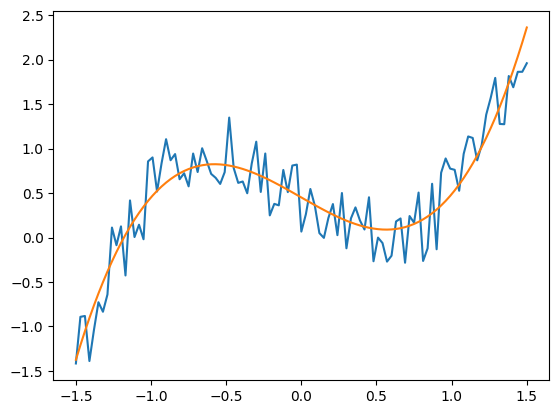

In [59]:
rng = np.random.default_rng()
x = np.linspace(-1.5, 1.5, 101)
y = x**3 - x + rng.random(len(x))

f = Poly(poly.polyfit(x, y, 3))
f
_ = plt.plot(x, y)
_ = plt.plot(x, f(x))

## Strings

In [67]:
# Multiply characters.

s = np.array(["a", "b", "c"])

np.char.multiply(s, 2)
np.char.add(s, s)

array(['aa', 'bb', 'cc'], dtype='<U2')

array(['aa', 'bb', 'cc'], dtype='<U2')

In [69]:
# Split
s = np.array(["a cat", "a hat", "a mouse trap"])
s
np.char.split(s)

array(['a cat', 'a hat', 'a mouse trap'], dtype='<U12')

array([list(['a', 'cat']), list(['a', 'hat']), list(['a', 'mouse', 'trap'])], dtype=object)

In [70]:
s = np.array(["a cat", "a hat", "a mouse trap"])
s
np.char.join("-", s)

array(['a cat', 'a hat', 'a mouse trap'], dtype='<U12')

array(['a- -c-a-t', 'a- -h-a-t', 'a- -m-o-u-s-e- -t-r-a-p'], dtype='<U23')

In [73]:
s = np.array(["A cat", "A hat", "A Mouse Trap"])
s
np.char.str_len(s)

array(['A cat', 'A hat', 'A Mouse Trap'], dtype='<U12')

array([ 5,  5, 12])

In [74]:
np.char.swapcase(s)

array(['a CAT', 'a HAT', 'a mOUSE tRAP'], dtype='<U12')

In [75]:
s = np.array(["A cat", "A hat", "A Mouse Trap"])
s
t = np.array(["A dog", "A hat", "A Cat Trap"])
t
s == t
np.char.equal(s, t)

array(['A cat', 'A hat', 'A Mouse Trap'], dtype='<U12')

array(['A dog', 'A hat', 'A Cat Trap'], dtype='<U10')

array([False,  True, False])

array([False,  True, False])

In [5]:
s = np.array(["a cat", "a dog", "a mouse trap", "fun game"])
s
np.char.count(s, "a")
np.char.find(s, "a")
np.char.startswith(s, "a")
np.char.endswith(s, "p")

array(['a cat', 'a dog', 'a mouse trap', 'fun game'], dtype='<U12')

array([2, 1, 2, 1])

array([0, 0, 0, 5])

array([ True,  True,  True, False])

array([False, False,  True, False])

## Misc

In [10]:
d = {"a": 1, "b": 2, "c": 3}
np.array((list(d.keys()), list(d.values())))
np.array(list(d))
np.array(list(d.items()))
np.asarray(d)

array([['a', 'b', 'c'],
       ['1', '2', '3']], dtype='<U21')

array(['a', 'b', 'c'], dtype='<U1')

array([['a', '1'],
       ['b', '2'],
       ['c', '3']], dtype='<U21')

array({'a': 1, 'b': 2, 'c': 3}, dtype=object)

In [15]:
s = np.array(["1.2", "2.3", "4.5"])
np.asarray(s, dtype=float)
np.fromiter(s, dtype=float)

np.fromstring("1.2 2.3 4.5", dtype=float, sep=" ")

array([1.2, 2.3, 4.5])

array([1.2, 2.3, 4.5])

array([1.2, 2.3, 4.5])

In [10]:
a = np.arange(15).reshape((3, 5))
a

a.tofile("numpy_test_1.csv", sep=", ")
np.savetxt("numpy_test_2.csv", a, delimiter=", ", fmt="%d", header="A B C D E")
np.loadtxt("numpy_test_2.csv", delimiter=",", dtype=int)

array([[ 0,  1,  2,  3,  4],
       [ 5,  6,  7,  8,  9],
       [10, 11, 12, 13, 14]])

array([[ 0,  1,  2,  3,  4],
       [ 5,  6,  7,  8,  9],
       [10, 11, 12, 13, 14]])

(32, 32, 4)

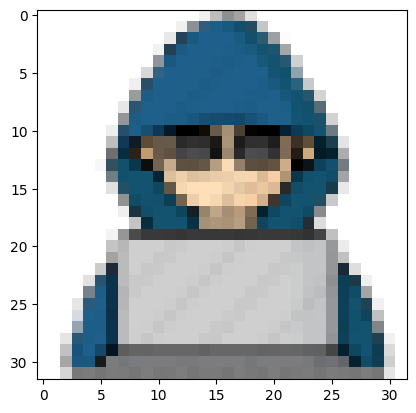

In [26]:
i = img.imread("numpy_coder.png")
i.shape
_ = plt.imshow(i)

(32, 32)

<Axes: ylabel='Count'>

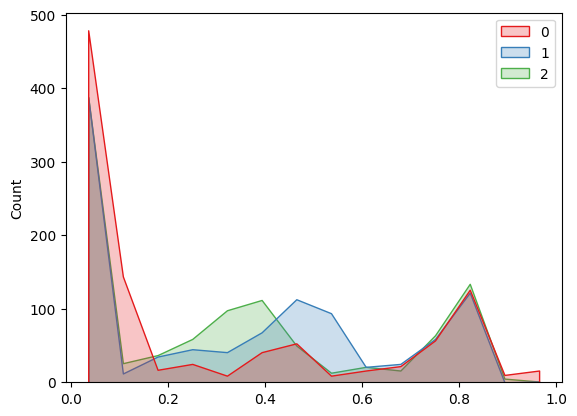

In [37]:
sns.histplot((i[..., 0].flat, i[..., 2].flat, i[..., 1].flat), palette="Set1", element="poly")